In [1]:
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from matplotlib import pyplot as plt

In [2]:
input_file = 'bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv'

In [3]:
df = pd.read_csv(input_file)  # this is by minute
df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

In [4]:
times = pd.to_datetime(df['Timestamp'], unit='s').dt
group = df.groupby([times.date, times.hour])  # this is by hour
df = group[df.columns.tolist()].mean()  # this is averaged by hour

In [24]:
def nan_outliers(series, max_std=3):
    outliers = np.abs(series - series.mean()) > (max_std * series.std())
    series[outliers] = np.nan
    return series

In [6]:
def diff(df, key, period=1):
    raw = df[key].diff(periods=period)
    return pd.Series(raw.values)

def ratio_last(df, key):
    raw = diff(df, key, period=1).divide(df[key].values)
    return pd.Series(raw)

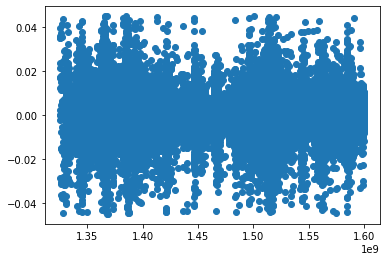

In [32]:
y = ratio_last(df, 'Close')
y = nan_outliers(y, max_std=5)
plt.scatter(df['Timestamp'], y)